In [1]:
import numpy as np
import pylab as pl 
import json as json
import pandas as pd
import math

/home/mauro/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
config=json.loads(open('settings.json','r').read())

In [5]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['pitch_on_y_axis'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 
df = float(sample_rate)/float(n)

### read the logs from CSV ###

In [6]:
logs = pd.read_csv('log_sec.csv')
logs

,timestamp,date,time,temperature,pressure,humidity,avg_pitch_,avg_roll,wave height,wave period
0,1.756508e+09,2025-08-29,23:48:09,38.761,1010.746,62.328,0.7,1.4,0.0000,0.0000
1,1.756508e+09,2025-08-29,23:51:10,38.822,1010.741,62.228,0.7,1.5,0.0000,0.0000
2,1.756508e+09,2025-08-29,23:54:10,38.848,1010.693,62.187,0.7,1.4,0.0000,0.0000
3,1.756508e+09,2025-08-29,23:57:10,38.822,1010.618,62.189,0.6,1.5,0.0000,0.0000
4,1.756508e+09,2025-08-30,00:00:10,38.845,1010.585,62.151,0.6,1.3,0.0000,0.0000
5,1.756509e+09,2025-08-30,00:03:10,38.877,1010.553,62.104,0.7,1.3,0.0000,0.0000
6,1.756509e+09,2025-08-30,00:06:10,38.897,1010.519,62.040,0.7,1.7,0.0000,0.0000
7,1.756509e+09,2025-08-30,00:09:10,38.866,1010.492,62.083,0.6,1.3,0.0000,0.0000
8,1.756509e+09,2025-08-30,00:12:10,38.816,1010.475,62.145,0.7,1.5,0.0000,0.0000
9,1.756509e+09,2025-08-30,00:15:10,38.749,1010.457,62.185,0.8,1.4,0.0000,0.0000


#### reindex on datetime ####

In [7]:
logs["datetime"] = pd.to_datetime(logs["timestamp"], unit="s")
logs.drop(logs[['timestamp','date', 'time']], axis=1, inplace=True)
logs['pressure'] = logs.pressure.astype(int)
logs.set_index('datetime', inplace=True)


### Plot ###

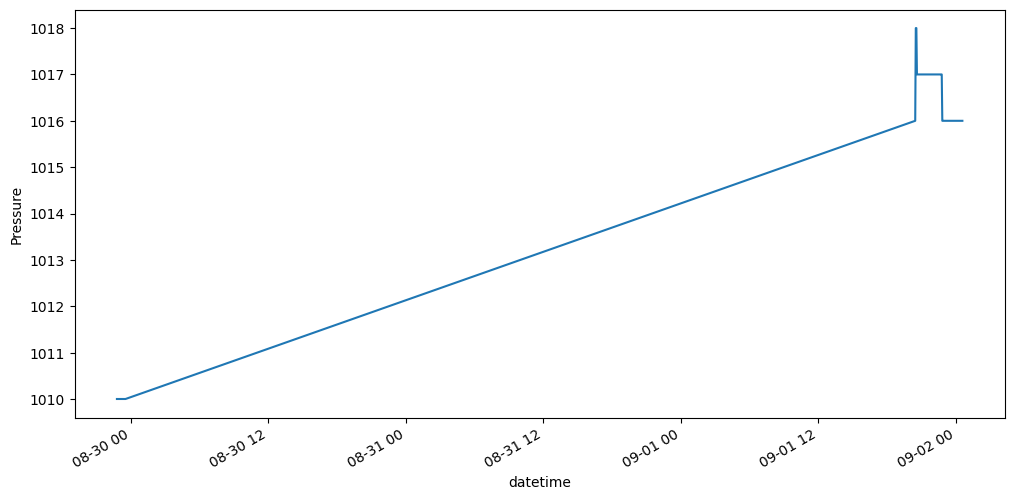

In [8]:
pl.ylabel('Pressure')
logs['pressure'].plot(figsize=[12,6])
pl.show()

#### Resample by hour ####

In [9]:
hourly_logs = logs.resample('d')

In [10]:
hourly_logs

datetime
2025-08-29    Axes(0.125,0.2;0.775x0.68)
2025-08-30    Axes(0.125,0.2;0.775x0.68)
2025-08-31    Axes(0.125,0.2;0.775x0.68)
2025-09-01    Axes(0.125,0.2;0.775x0.68)
2025-09-02    Axes(0.125,0.2;0.775x0.68)
Freq: D, Name: humidity, dtype: object

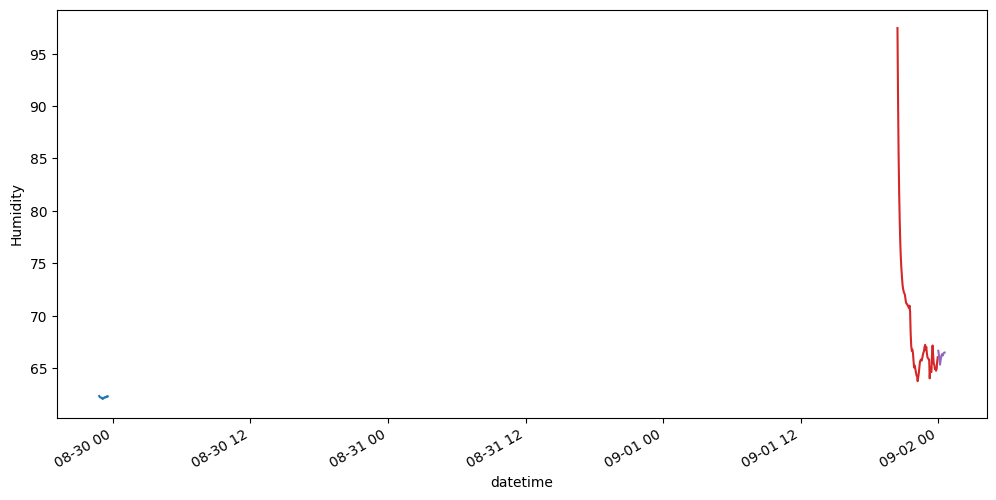

In [11]:
pl.ylabel('Humidity')
hourly_logs['humidity'].plot(figsize=[12,6])


datetime
2025-08-29    Axes(0.125,0.2;0.775x0.68)
2025-08-30    Axes(0.125,0.2;0.775x0.68)
2025-08-31    Axes(0.125,0.2;0.775x0.68)
2025-09-01    Axes(0.125,0.2;0.775x0.68)
2025-09-02    Axes(0.125,0.2;0.775x0.68)
Freq: D, Name: pressure, dtype: object

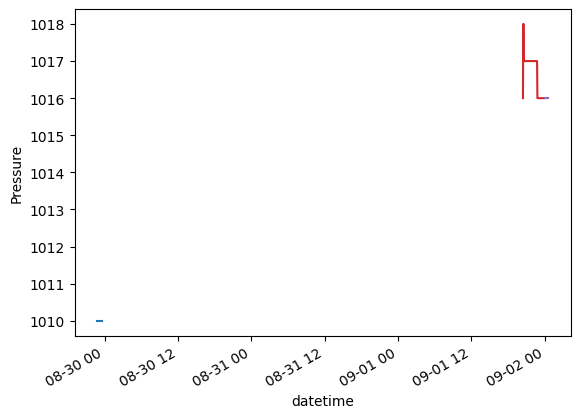

In [12]:
pl.ylabel('Pressure')
hourly_logs["pressure"].plot()


### Debugging ###

In [47]:
npydir = 'npyfiles/'
run = '2025_09_02_00_30' # manual simulation of about 1 mt oscillations

In [48]:
freqs    = np.load(f'{npydir}freqs_{run}.npy')
signal   = np.load(f'{npydir}signal_{run}.npy')
amp_spec = np.load(f'{npydir}amp_spec_{run}.npy')
heights  = np.load(f'{npydir}heights_{run}.npy')
print('signal: ', len(signal), 'amp_spec: ', len(amp_spec))

signal:  720 amp_spec:  38


In [40]:
#signal = np.load(f'{npydir}signal_corr.npy')

In [49]:
w=40
mavg_signal = moving_average(signal,w)
ls =  len(signal)
print(len(signal),len(mavg_signal))

720 681


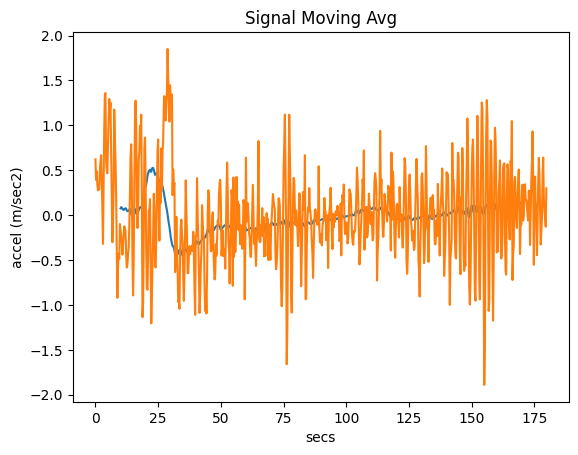

In [50]:
pl.title('Signal Moving Avg')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(w, ls-w )],mavg_signal[w:ls-w])
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal[0:ls])
pl.show()

subtract moving average from signal to clean low frequencies

In [51]:
signal_corr = np.concatenate([signal[:w-1], signal[w-1:]-mavg_signal] )

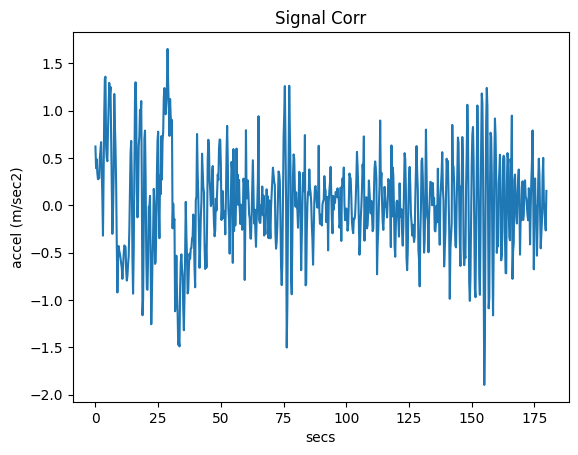

In [52]:
pl.title('Signal Corr')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal_corr[0:ls])
pl.show()

In [53]:
np.save(f'{npydir}signal_corr', signal_corr)

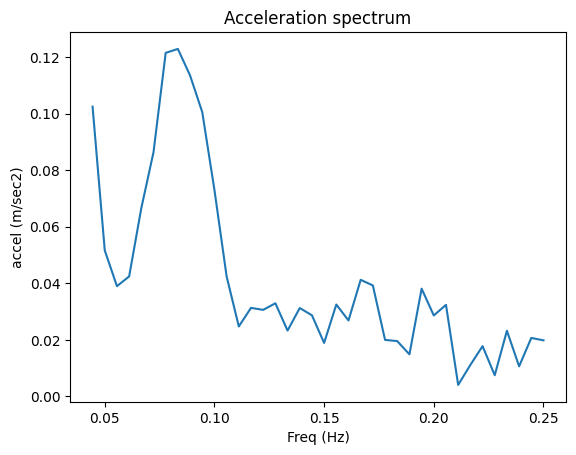

In [31]:
pl.title('Acceleration spectrum')
pl.xlabel('Freq (Hz)')
pl.ylabel('accel (m/sec2)')
pl.plot(freqs, amp_spec)
pl.show()

In [22]:
w=4
mavg = moving_average(amp_spec, w)
max_index = np.argmax(mavg)+int(w/2)
dom_freq = freqs[max_index]
dom_per = 1/dom_freq
dom_per

11.25

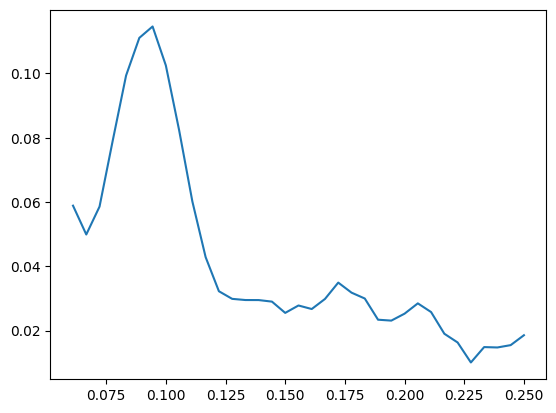

In [23]:
mavg = pl.plot(freqs[3:], mavg)

In [ ]:
pl.title('Displacement Frequency Spectrum')
pl.xlabel('freq (Hz)')
pl.ylabel('height (mt)')
pl.plot(freqs, heights)
pl.show()

In [ ]:
avg_acc = sum(amp_spec)/(len(amp_spec))
avg_acc

In [ ]:
heights[2:]

In [ ]:
max_index = np.argmax(heights[2:])
max_index

In [ ]:
psd = (heights[2:]**2)/freqs[2:]
psd

In [ ]:
m0  = sum(psd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height